In [ ]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm

In [3]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

###    Step 1. Load (or download) Dataset

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

100.0%
100.0%
100.0%
100.0%


### Step 2. Define our model: Variational AutoEncoder (VAE)

In [5]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


In [7]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [8]:
scale_factor = 4

x_dim = 28
x_inp_dim  = int(x_dim / scale_factor)

hidden_dim = 200
latent_dim = 100

lr = 1e-3
batch_size = 100
epochs = 30


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [9]:
encoder = Encoder(input_dim=x_inp_dim**2, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim**2)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [10]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [11]:
import torch.nn.functional as nnf

In [12]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        x_inp = x_inp.view(batch_size, x_inp_dim**2)
        x_inp = x_inp.to(DEVICE)

        x = x.view(batch_size, x_dim**2)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x_inp)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  193.96989486057493
	Epoch 2 complete! 	Average Loss:  153.94563372221933
	Epoch 3 complete! 	Average Loss:  143.66091076272954
	Epoch 4 complete! 	Average Loss:  139.5687813184735
	Epoch 5 complete! 	Average Loss:  136.6814940265025
	Epoch 6 complete! 	Average Loss:  134.53075405623957
	Epoch 7 complete! 	Average Loss:  133.02558407893363
	Epoch 8 complete! 	Average Loss:  131.660688859688
	Epoch 9 complete! 	Average Loss:  130.65562289688543
	Epoch 10 complete! 	Average Loss:  129.76702844584725
	Epoch 11 complete! 	Average Loss:  129.01995966584934
	Epoch 12 complete! 	Average Loss:  128.35784843228296
	Epoch 13 complete! 	Average Loss:  127.68317022511478
	Epoch 14 complete! 	Average Loss:  127.16568212646077
	Epoch 15 complete! 	Average Loss:  126.65046449486123
	Epoch 16 complete! 	Average Loss:  126.21645403471932
	Epoch 17 complete! 	Average Loss:  125.87198563360809
	Epoch 18 complete! 	Average Loss:  125.50697616144095
	

### Step 5. Generate images from test dataset

In [15]:
import matplotlib.pyplot as plt

In [16]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        x_inp = x_inp.view(batch_size, x_inp_dim**2)
        x_inp = x_inp.to(DEVICE)

        x = x.view(batch_size, x_dim**2)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x_inp)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [21]:
def show_image(x, x_inp, x_hat, n):
    x = x.view(batch_size, x_dim, x_dim)
    x_inp = x_inp.view(batch_size, x_inp_dim, x_inp_dim)
    x_hat = x_hat.view(batch_size, x_dim, x_dim)


    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        axs[0, i].imshow(x[i].cpu().numpy(), cmap='gray')
        axs[0, i].axis('off')

        axs[1, i].imshow(x_inp[i].cpu().numpy(), cmap='gray')
        axs[1, i].axis('off')

        axs[2, i].imshow(x_hat[i].cpu().numpy(), cmap='gray')
        axs[2, i].axis('off')

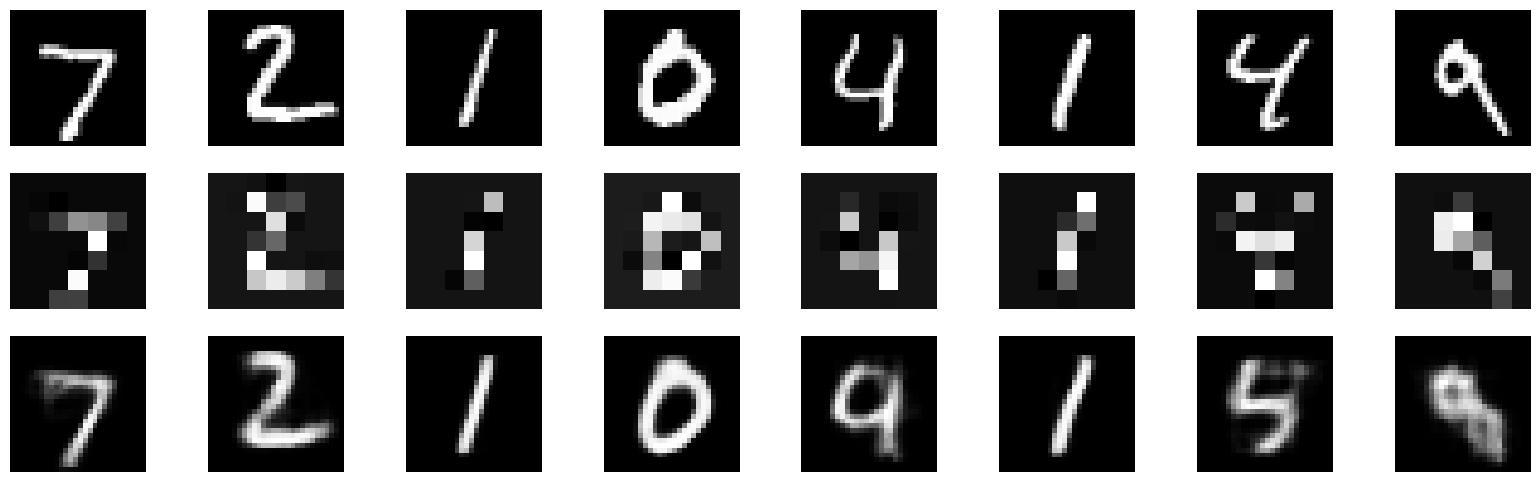

In [24]:
show_image(x, x_inp, x_hat, 8)